# Housing Prices Prediction 
In this notebook, I intend to use the <a href="https://www.kaggle.com/competitions/home-data-for-ml-course/overview">Housing Prices Competiton</a> from Kaggle to apply data processing, exploratory data analysis, and finally use regression to predict sales prices for houses. 

In [1]:
import pandas as pd
import numpy as np

# Data Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Initial Data Cleaning

### Duplicates and empty rows

In [3]:
# Remove all duplicate rows, rows all empty fields

train_df = train_df.drop_duplicates()
train_df = train_df.dropna(how="all")

# Remove rows if target is missing
train_df = train_df.dropna(subset=['SalePrice'])


### Missing values

In [4]:
# Identify which columns have missing values
missing = train_df.isna().sum()[train_df.isna().sum().values > 0].sort_values(ascending=False)
print(missing)

# Index of columns with missing values 
print(missing.index)

# Categorical Variables with missing values 
missing_categorical = train_df[missing.index].select_dtypes(include=["object"])
print(missing_categorical)

# Numerical Variables with missing values 
missing_numerical = train_df[missing.index].select_dtypes(exclude=["object"])
print(missing_numerical)


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64
Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
       'LotFrontage', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure',
       'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrArea', 'Electrical'],
      dtype='object')
     PoolQC MiscFeature Alley  Fence MasVnrType FireplaceQu GarageType  \
0       NaN         NaN   NaN    NaN    BrkFace         NaN     Attchd   
1       NaN         NaN   NaN    NaN        NaN          TA     Attchd   
2       NaN         NaN   NaN    NaN    BrkFace        

Large number of missing values for categorical variables, indicates that houses do not have these features, we will replace with 'NA'.
Only three numerical variables have missing values, we will replace the missing values with 0. 

In [5]:
# Replace NA values for categorical variables
categorical = train_df.select_dtypes(include=["object"])
train_df[categorical.columns] = categorical.fillna("NA") 

# Replace NaN values for numerical variables 
numerical = train_df.select_dtypes(exclude=["object"])
train_df[numerical.columns] = numerical.fillna(0)

missing = train_df.isna().sum()[train_df.isna().sum().values > 0].sort_values(ascending=False)
print(missing)


Series([], dtype: int64)


## Data Summary and Visualization

In [6]:
# Function to create scrollable tables
def create_scrollable(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id= "{table_id}" style="height:400px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [7]:
# MSSubClass should be a categorical variable
train_df["MSSubClass"] = train_df["MSSubClass"].astype("object")

The data is highly skewed due to the presence of missing values ('NA' / '0') that indicate the absence of a certain feature. These values dominate one end of the distribution, creating the skewness

In [8]:
def summarise_data(df):
    summary = {
        "Feature": [],
        "Data Type": [],
        "Min": [],
        "Max": [],
        "Mean": [],
        "Std": [],
        "Lower Quartile": [],
        "Median": [],
        "Upper Quartile": [],
        "Mode": []
    }

    summary_stats = df.describe().T

    # Data Types and Summary Statistics
    for column in df.columns: 
        if df[column].dtype in [np.int64, np.float64]:
            summary["Feature"].append(column)
            summary["Data Type"].append(df[column].dtype)
            summary["Min"].append(summary_stats.loc[column, "min"])
            summary["Max"].append(summary_stats.loc[column, "max"])
            summary["Mean"].append(summary_stats.loc[column, "mean"])
            summary["Std"].append(summary_stats.loc[column, "std"])
            summary["Lower Quartile"].append(summary_stats.loc[column, "25%"])
            summary["Median"].append(summary_stats.loc[column, "50%"])
            summary["Upper Quartile"].append(summary_stats.loc[column, "75%"])

            summary["Mode"].append(df[column].mode()[0])
        
        # else: 
        #     summary["Min"].append("-")
        #     summary["Max"].append("-")
        #     summary["Mean"].append("-")
        #     summary["Std"].append("-")
        #     summary["Lower Quartile"].append("-")
        #     summary["Median"].append("-")
        #     summary["Upper Quartile"].append("-")

        #     summary["Mode"].append(df[column].mode()[0])

    
    return pd.DataFrame(summary)

html = create_scrollable(summarise_data(train_df), 'summary', "Summary Statistics")
display(HTML(html))

,Feature,Data Type,Min,Max,Mean,Std,Lower Quartile,Median,Upper Quartile,Mode
0,Id,int64,1.0,1460.0,730.500000,421.610009,365.75,730.5,1095.25,1.0
1,LotFrontage,float64,0.0,313.0,57.623288,34.664304,42.00,63.0,79.00,0.0
2,LotArea,int64,1300.0,215245.0,10516.828082,9981.264932,7553.50,9478.5,11601.50,7200.0
3,OverallQual,int64,1.0,10.0,6.099315,1.382997,5.00,6.0,7.00,5.0
4,OverallCond,int64,1.0,9.0,5.575342,1.112799,5.00,5.0,6.00,5.0
5,YearBuilt,int64,1872.0,2010.0,1971.267808,30.202904,1954.00,1973.0,2000.00,2006.0
6,YearRemodAdd,int64,1950.0,2010.0,1984.865753,20.645407,1967.00,1994.0,2004.00,1950.0
7,MasVnrArea,float64,0.0,1600.0,103.117123,180.731373,0.00,0.0,164.25,0.0
8,BsmtFinSF1,int64,0.0,5644.0,443.639726,456.098091,0.00,383.5,712.25,0.0
9,BsmtFinSF2,int64,0.0,1474.0,46.549315,161.319273,0.00,0.0,0.00,0.0


Visualise categorical variables using boxplots

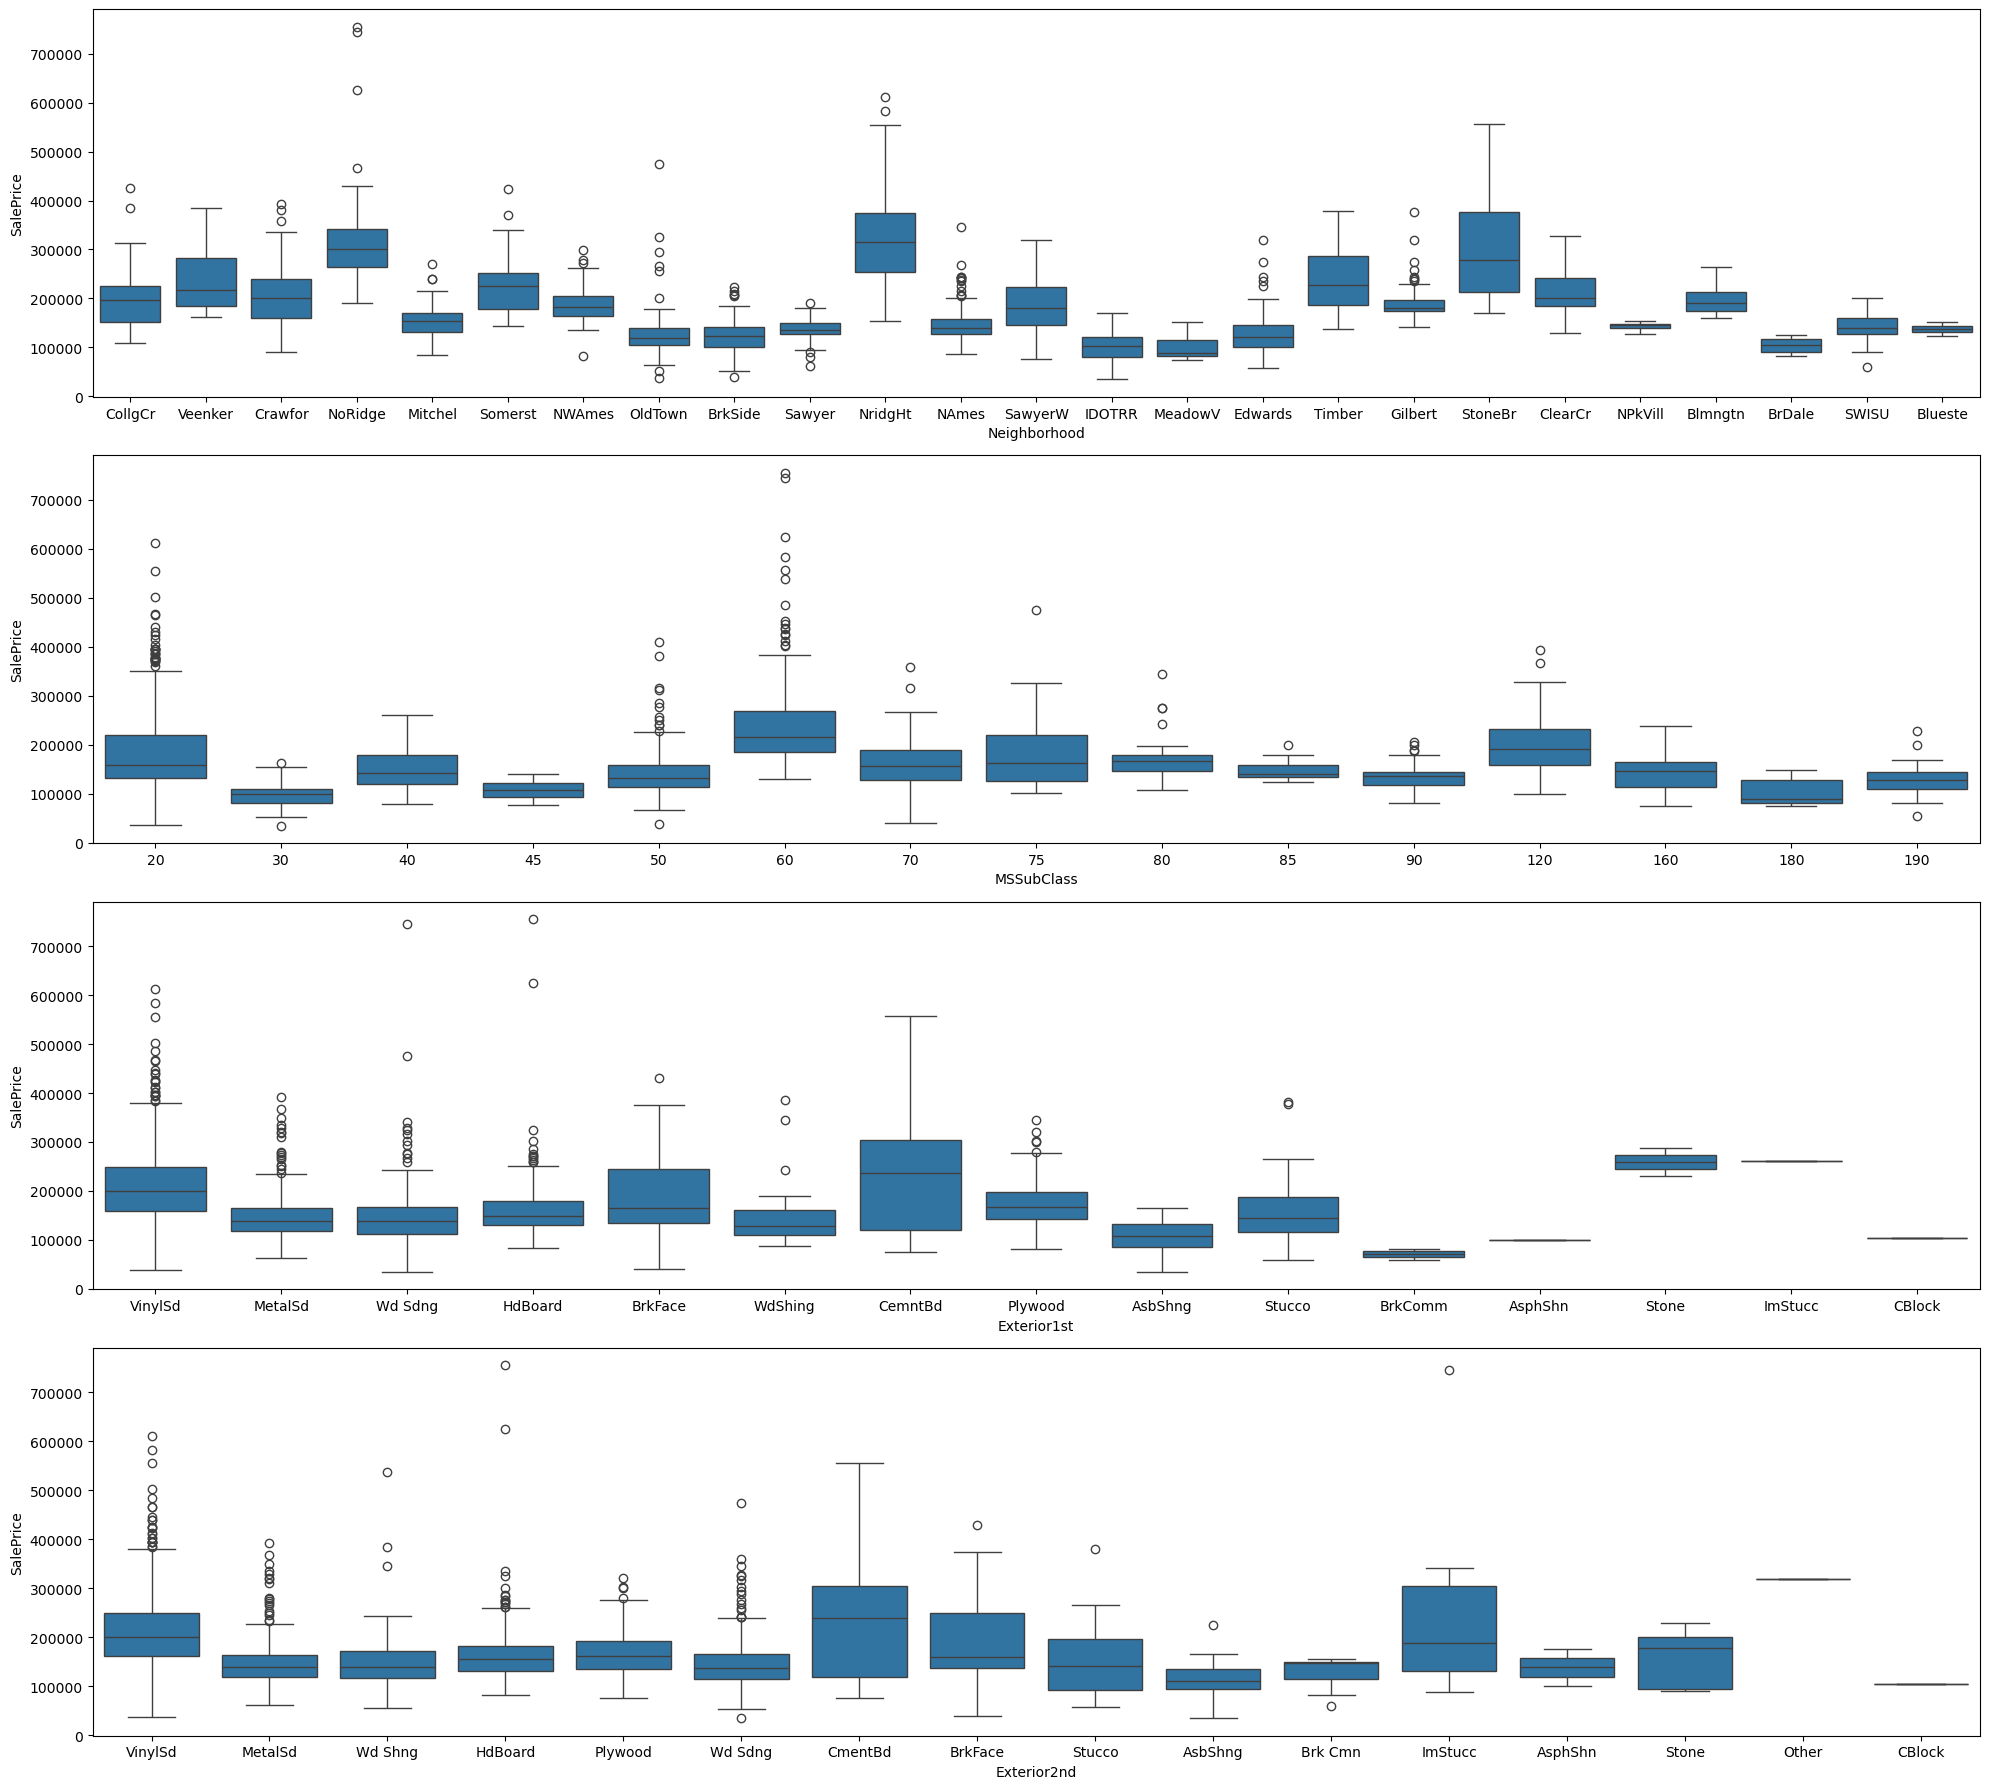

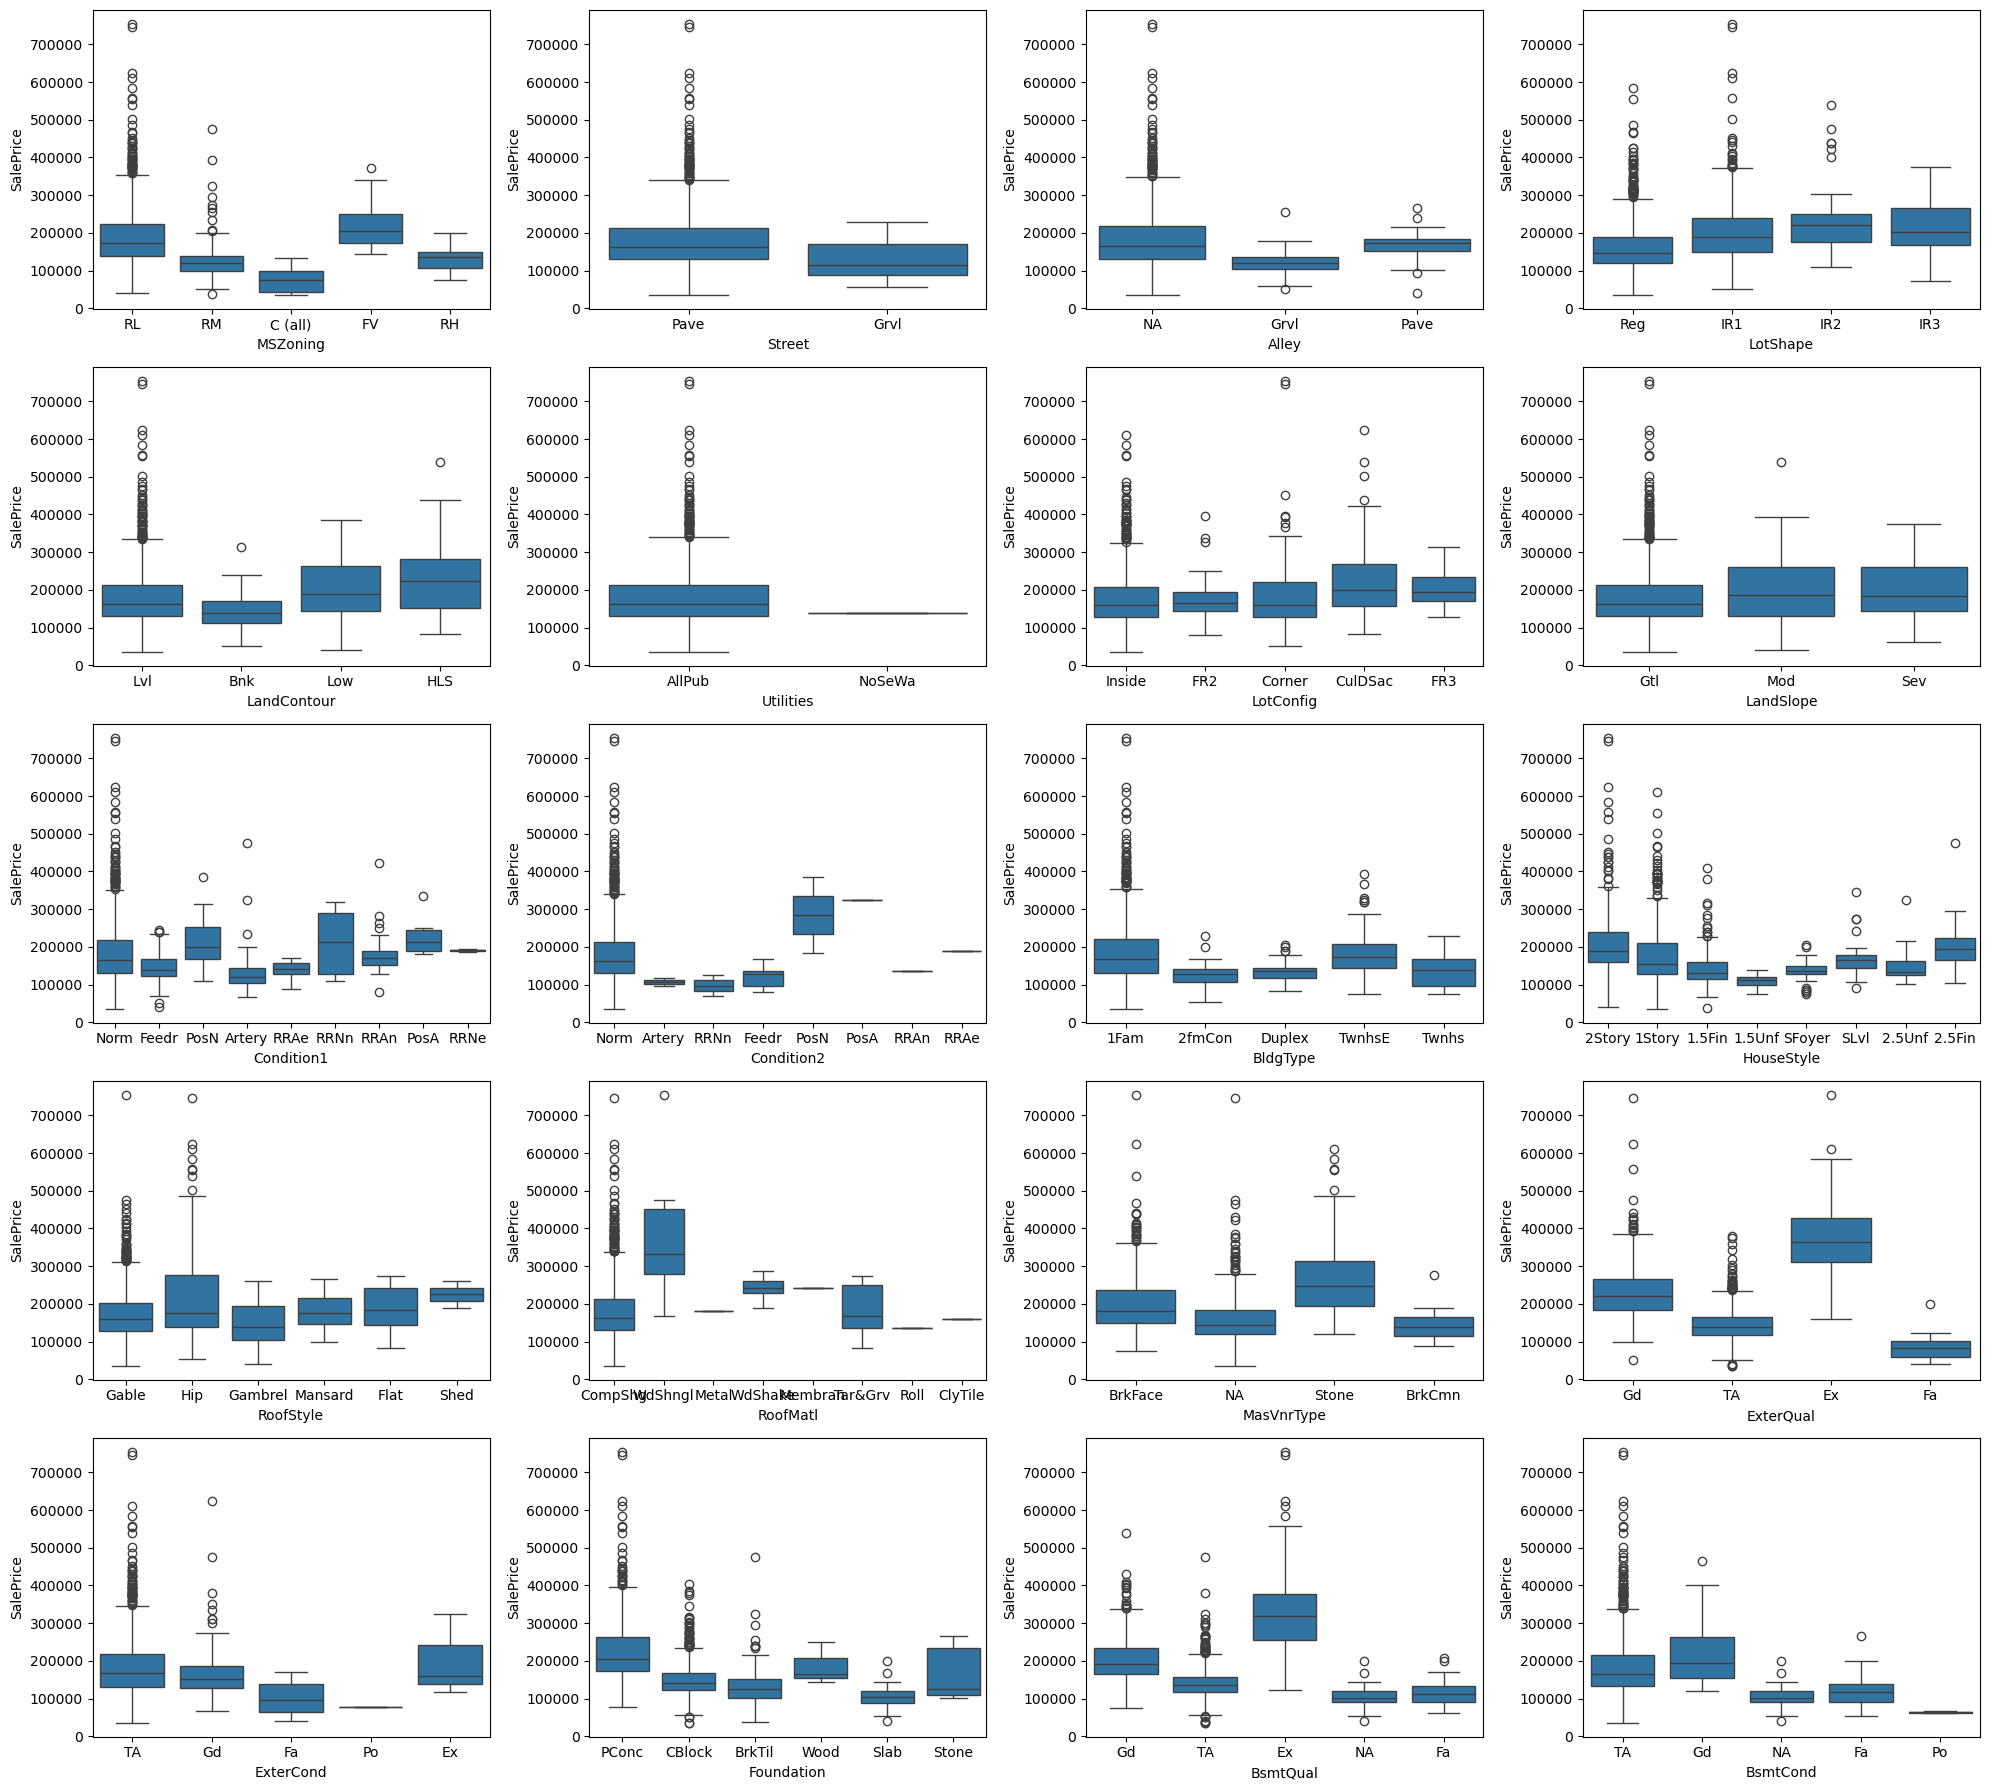

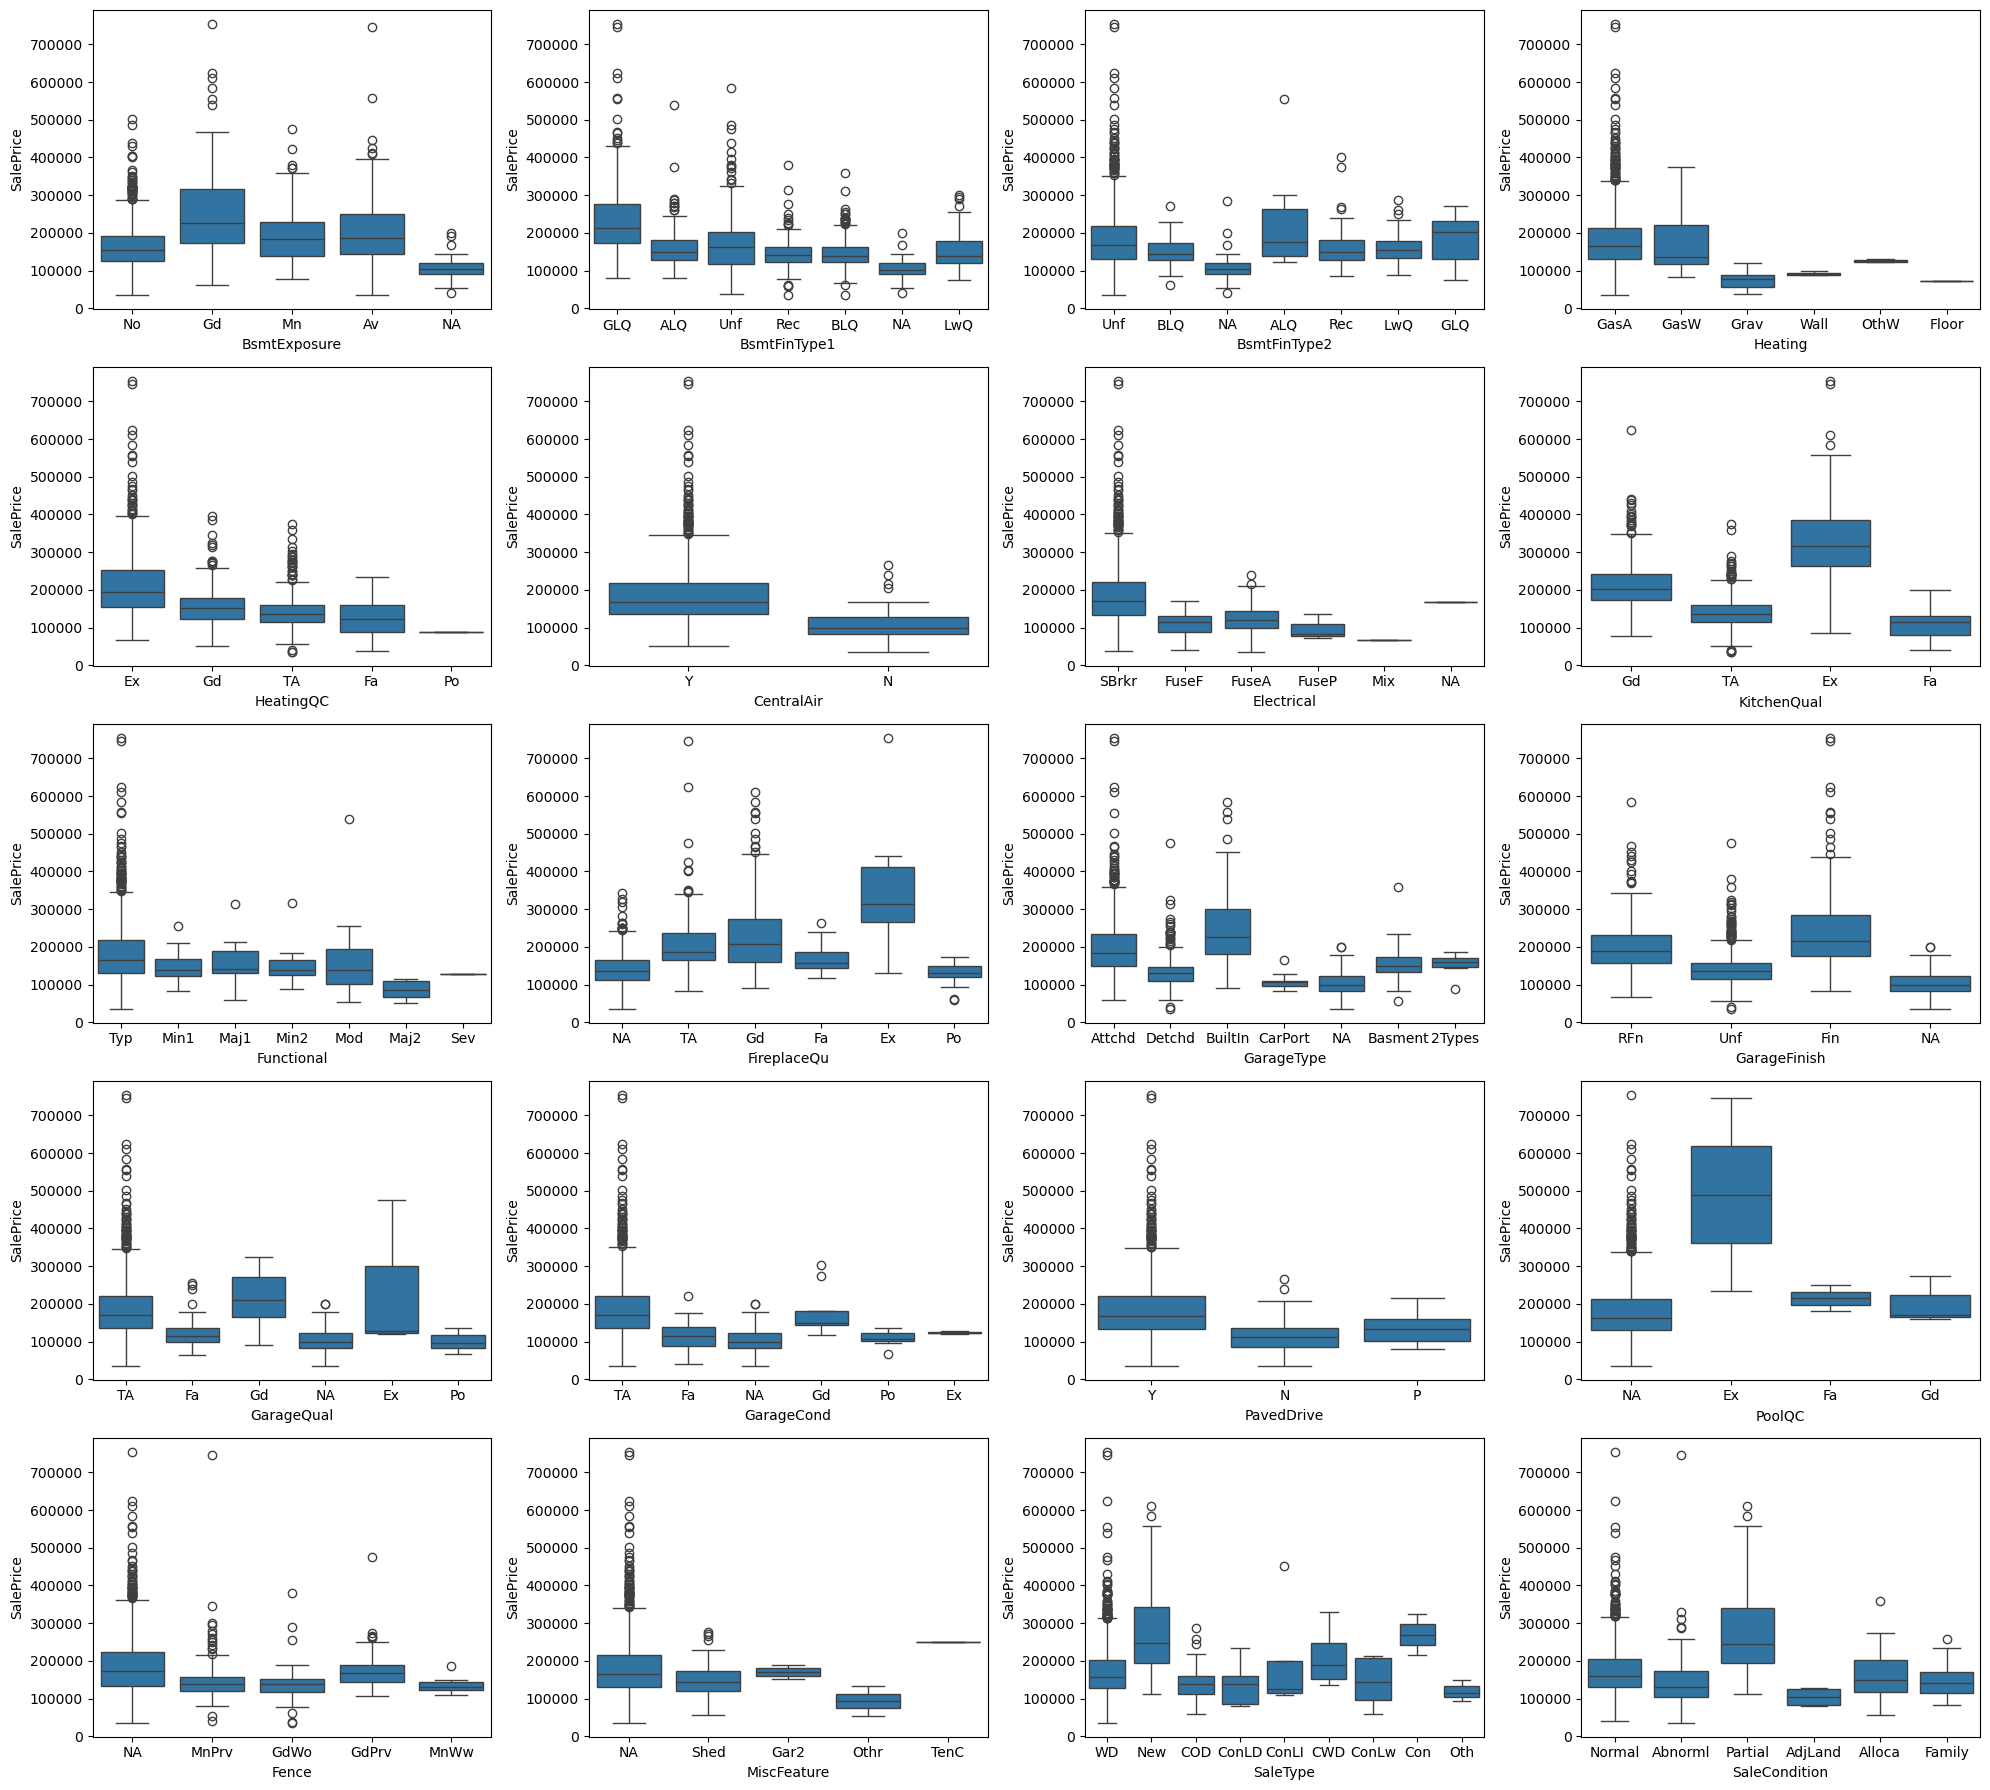

In [9]:
# Select categorical features
categorical_columns = train_df.select_dtypes(include=["object"]).columns

# Drop columns with too many categories
drop_columns = ["Neighborhood", "MSSubClass", "Exterior1st", "Exterior2nd"]



# Create boxplots for all categorical features against SalePrice

# Bigger plots for columns with many categories
plt.figure(figsize=(20, 18))
for index, feature in enumerate(train_df[drop_columns]):
    plt.subplot(len(drop_columns), 1, index + 1)
    sns.boxplot(x = train_df[feature], y = train_df['SalePrice'])

plt.tight_layout()

categorical_columns = categorical_columns.drop(drop_columns)
plt.figure(figsize=(20, 18))

for index, feature in enumerate(categorical_columns[:len(categorical_columns)//2]):
    plt.subplot(5, 4, index + 1)
    sns.boxplot(x = train_df[feature], y = train_df['SalePrice'])

plt.tight_layout()

plt.figure(figsize=(20, 18))

for index, feature in enumerate(categorical_columns[len(categorical_columns)//2:]):
    plt.subplot(5, 4, index + 1)
    sns.boxplot(x = train_df[feature], y = train_df['SalePrice'])

plt.tight_layout()

plt.show()

Visualize numerical data for easier identification of outliers.

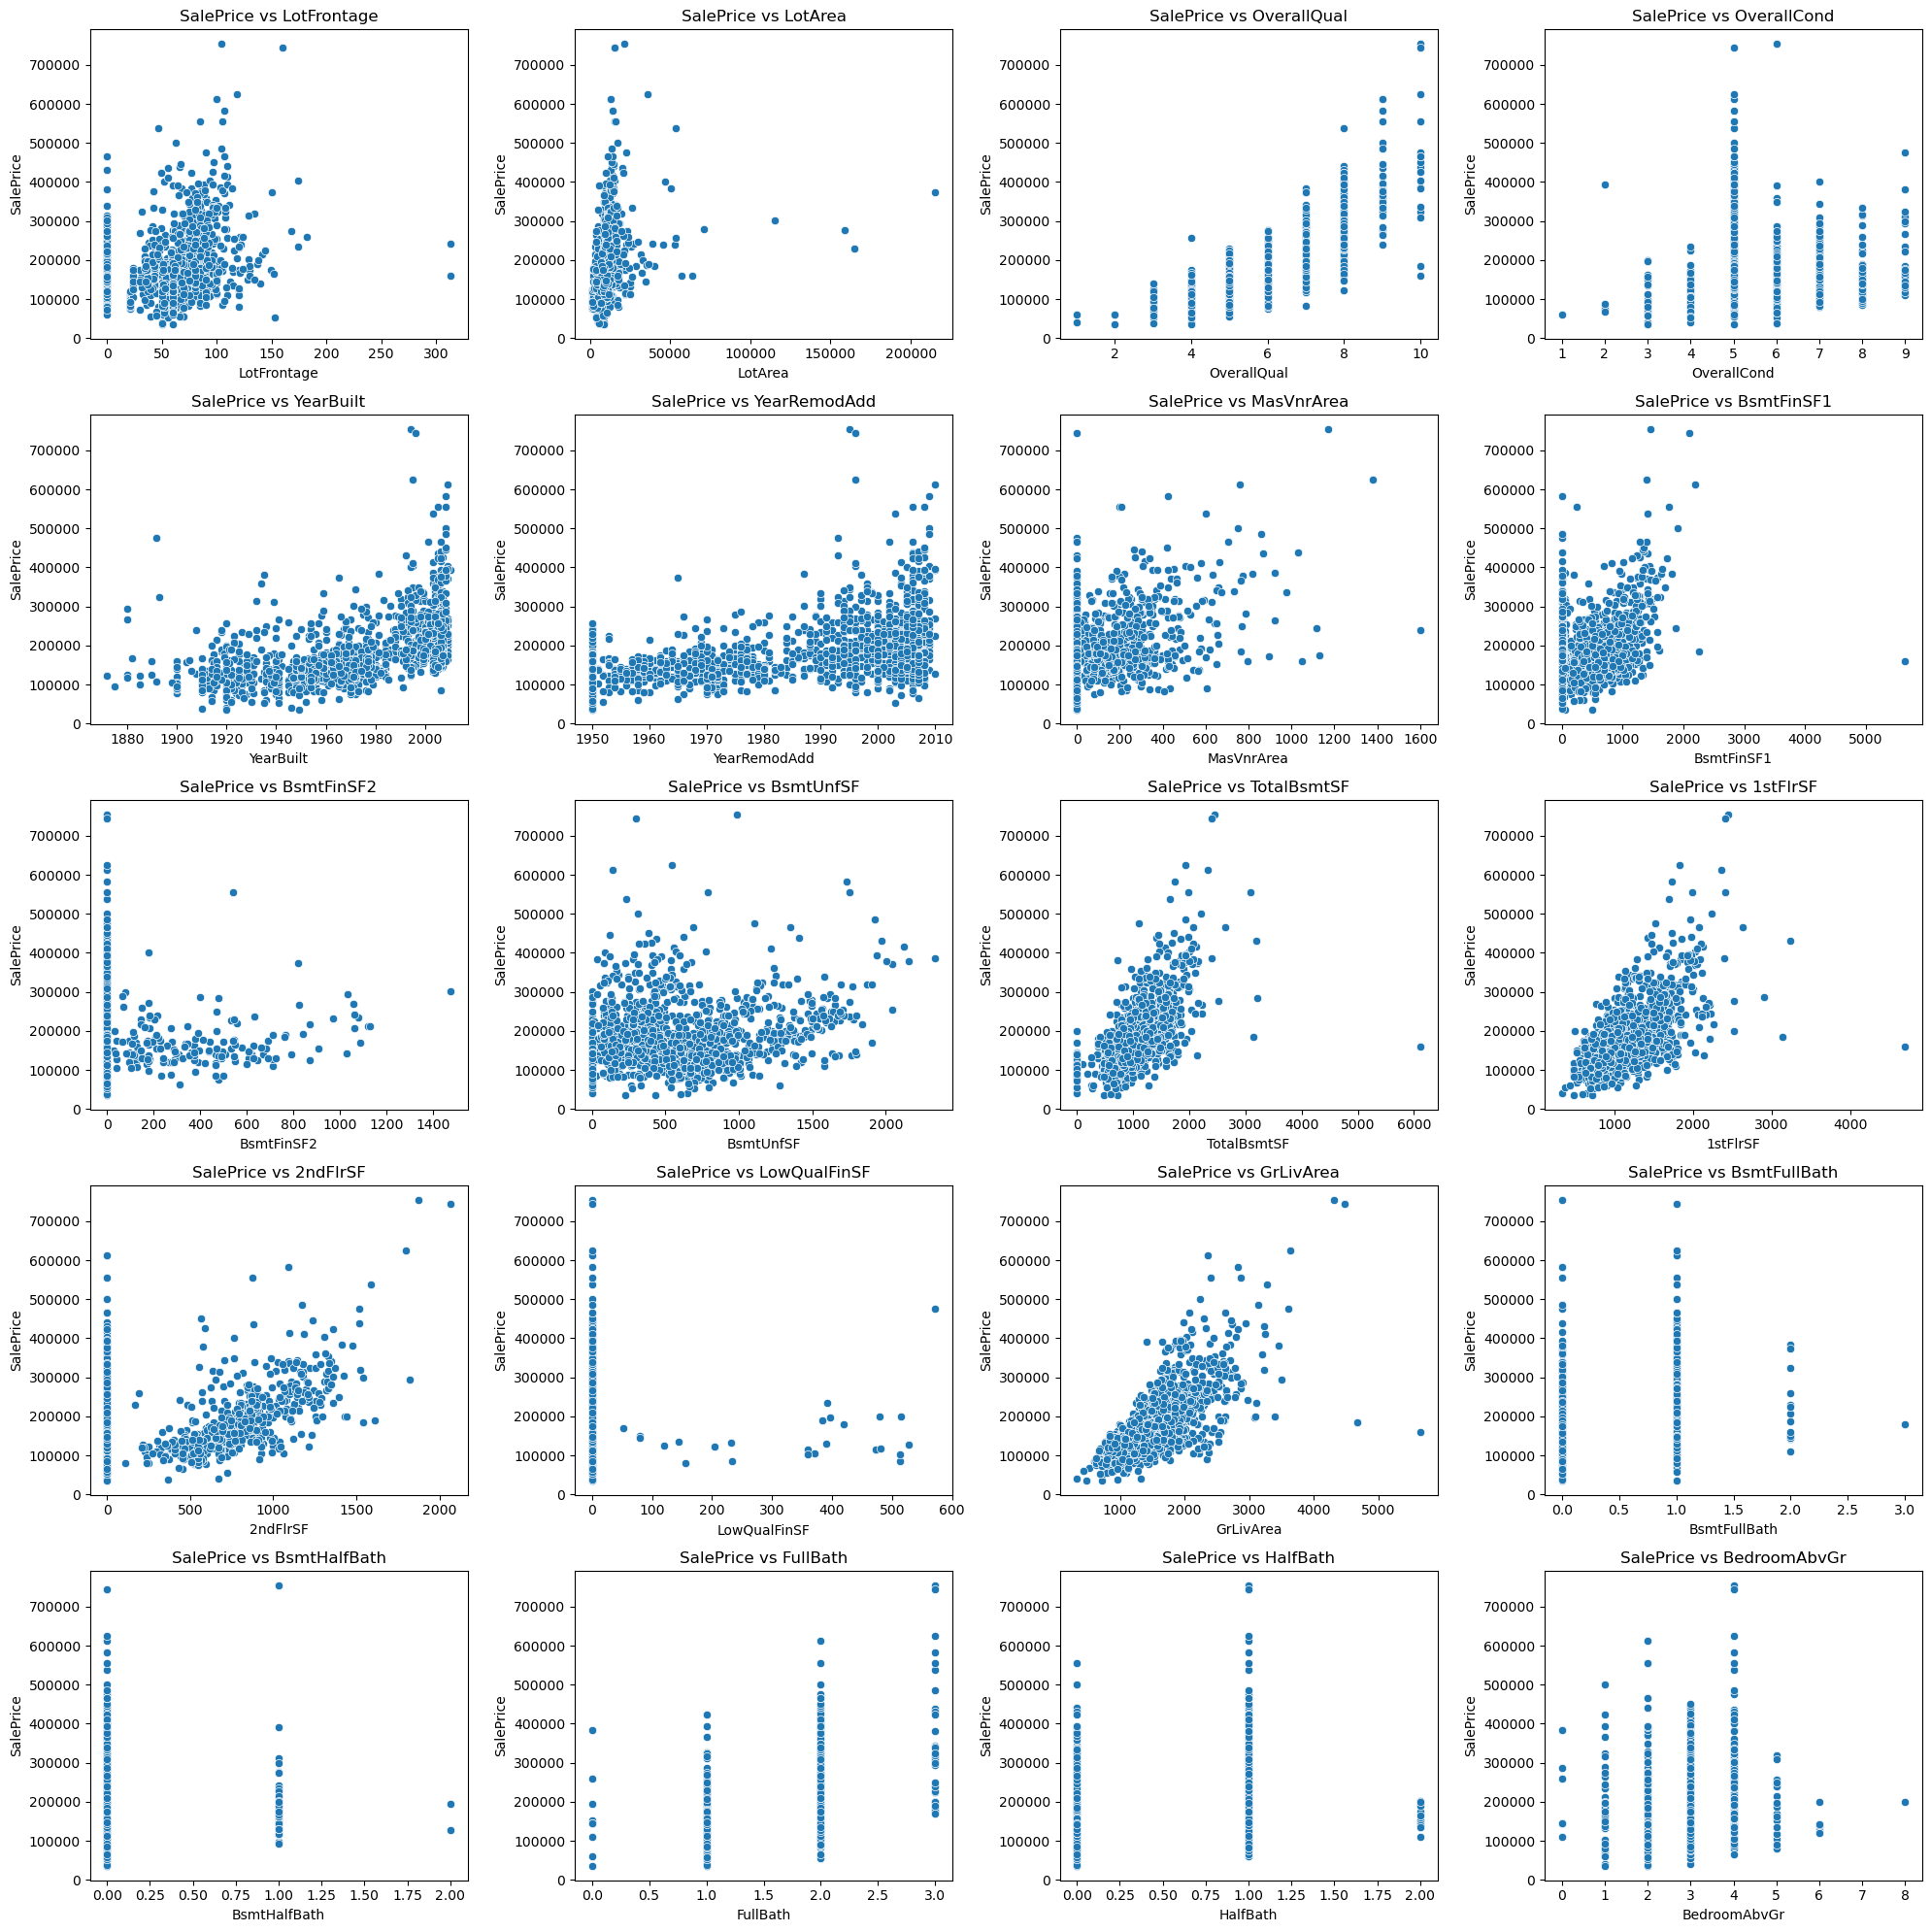

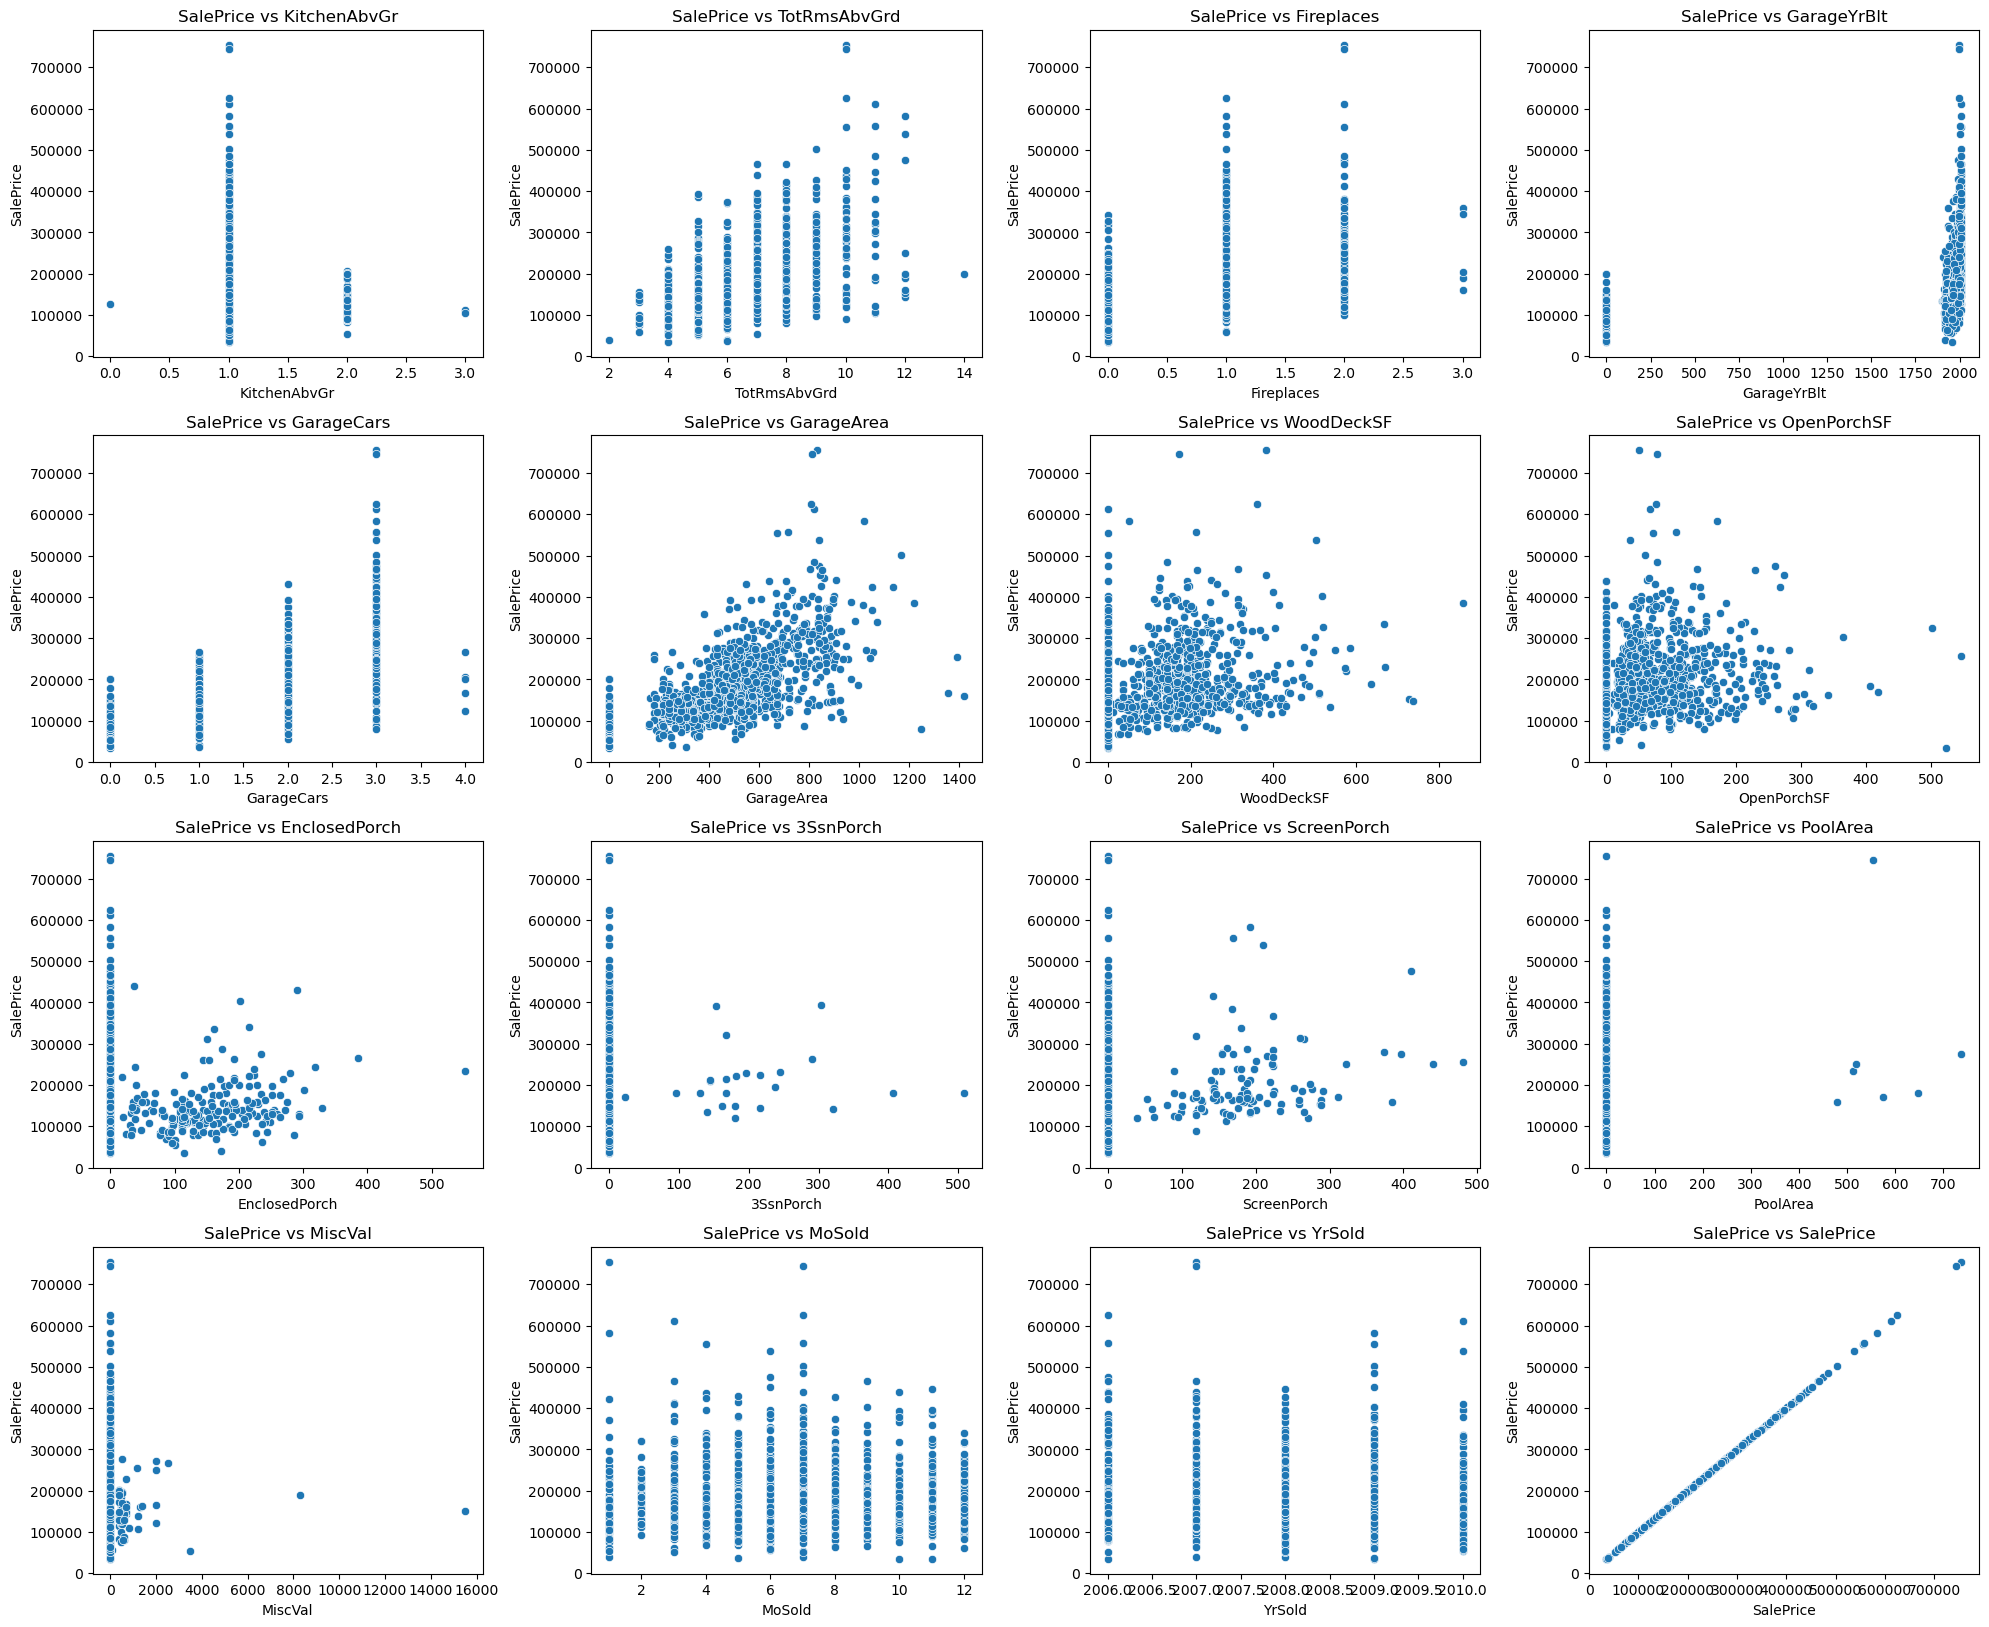

In [10]:
# Select numerical features
numerical_columns = train_df.select_dtypes(exclude=["object"]).columns
numerical_columns = numerical_columns.drop(["Id"])

# Create scatterplots for all numerical features against SalePrice
plt.figure(figsize=(20, 20))

for index, feature in enumerate(numerical_columns[:len(numerical_columns)//2 + 2]):
    plt.subplot(5, 4, index + 1)
    sns.scatterplot(x = train_df[feature], y = train_df["SalePrice"])
    plt.title(f"SalePrice vs {feature}")

plt.tight_layout()

plt.figure(figsize=(20, 20))

for index, feature in enumerate(numerical_columns[len(numerical_columns)//2 + 2:]):
    plt.subplot(5, 4, index+1)
    sns.scatterplot(x = train_df[feature], y = train_df["SalePrice"])
    plt.title(f"SalePrice vs {feature}")

plt.tight_layout()

plt.show()

In [11]:
# Drop Outliers 
outliers = []

outliers.extend(train_df[train_df['LotFrontage'] > 300].index.tolist())
outliers.extend(train_df[train_df['LotArea'] > 100000].index.tolist())
outliers.extend(train_df[(train_df['OverallCond'] == 2) & (train_df['SalePrice'] > 200000)].index.tolist())
outliers.extend(train_df[(train_df['OverallCond'] == 6) & (train_df['SalePrice'] > 600000)].index.tolist())
outliers.extend(train_df[train_df['MasVnrArea'] > 1250].index.tolist())
outliers.extend(train_df[train_df['BsmtFinSF1'] > 4000].index.tolist())
outliers.extend(train_df[train_df['BsmtFinSF2'] > 1300].index.tolist())
outliers.extend(train_df[train_df['TotalBsmtSF'] > 4000].index.tolist())
outliers.extend(train_df[train_df['1stFlrSF'] > 4000].index.tolist())
outliers.extend(train_df[(train_df['LowQualFinSF'] > 500) & (train_df['SalePrice'] > 400000)].index.tolist())
outliers.extend(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 400000)].index.tolist())
outliers.extend(train_df[(train_df['BsmtHalfBath'] == 1) & (train_df['SalePrice'] > 500000)].index.tolist())
outliers.extend(train_df[train_df['TotRmsAbvGrd'] > 12.5].index.tolist())
outliers.extend(train_df[train_df['WoodDeckSF'] > 800].index.tolist())
outliers.extend(train_df[train_df['OpenPorchSF'] > 450].index.tolist())
outliers.extend(train_df[train_df['EnclosedPorch'] > 400].index.tolist())
outliers.extend(train_df[train_df['SalePrice'] > 700000].index.tolist())

outliers = set(outliers)
train_df = train_df.drop(outliers)

## Feature Engineering

In [12]:
# Combine Porch Area
train_df["TotalPorch"] = train_df["OpenPorchSF"] + train_df["EnclosedPorch"] + train_df["3SsnPorch"] + train_df["ScreenPorch"]

# Baths 
train_df["FullBath"] = train_df["BsmtFullBath"] + train_df["FullBath"]
train_df["HalfBath"] = train_df["HalfBath"] + train_df["BsmtHalfBath"]

# Basement Finished
train_df["BsmtFinSF"] = train_df["BsmtFinSF1"] + train_df["BsmtFinSF2"]

# Drop columns
# Drop GarageCars, TotRmsAbvGrd, BsmtFinSF1, BsmtFinSF2, TotalBsmtSF, OverallCond, LowQualFinSF, PoolArea, MiscVal, MoSold, YrSold
drop_cols = ["GarageCars", "TotRmsAbvGrd", "BsmtFinSF1", "BsmtFinSF2", "TotalBsmtSF", "BsmtHalfBath", "BsmtFullBath", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "OverallCond"\
             ,"LowQualFinSF", "PoolArea", "MiscVal", "MoSold", "YrSold"]
train_df = train_df.drop(columns=drop_cols)

In [13]:
# Remove outliers
outliers = []

outliers.extend(train_df[train_df["BsmtFinSF"] > 5000].index.tolist())
outliers.extend(train_df[train_df["TotalPorch"] > 1000].index.tolist())

outliers = set(outliers)
train_df = train_df.drop(outliers)

## Feature Selection

Identify which features have strong correlations with the target

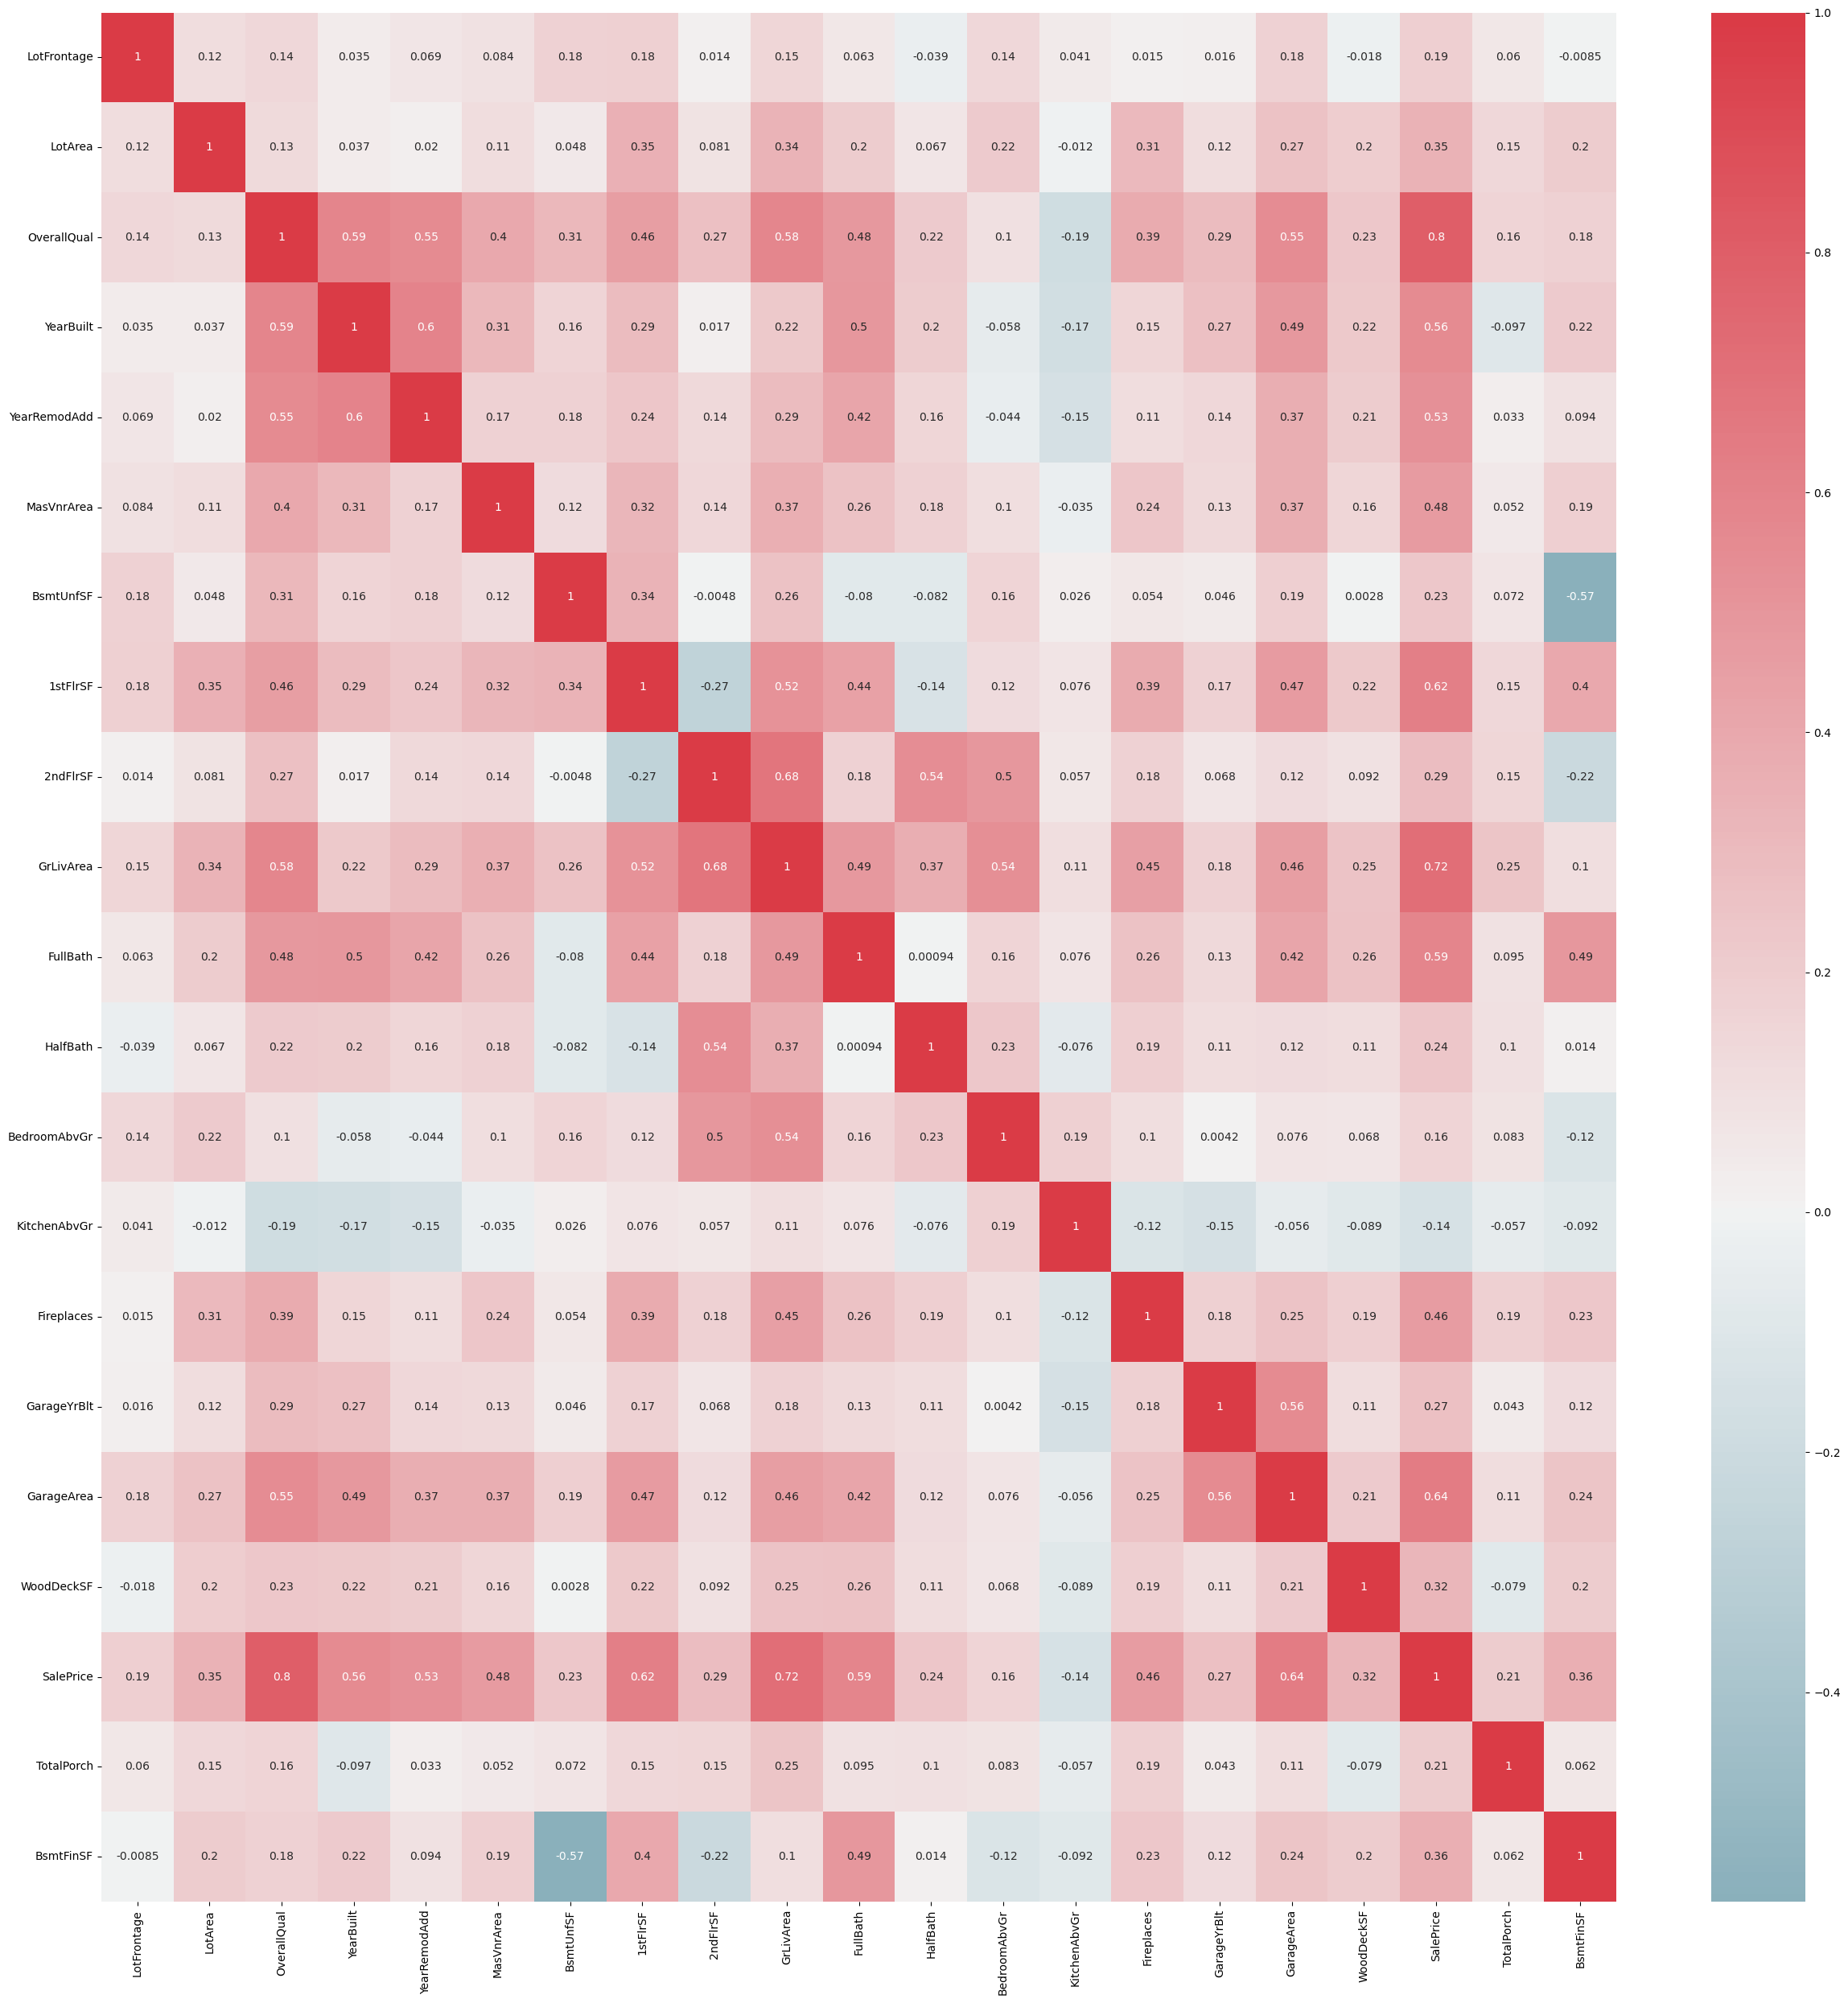

In [20]:
plt.figure(figsize=(25,25))
numerical_features = train_df.select_dtypes(exclude=["object"])
numerical_features = numerical_features.drop(columns=["Id"])
sns.heatmap(numerical_features.corr(), annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), center=0.0)
plt.tight_layout()
plt.show()